# DSPP Simulation

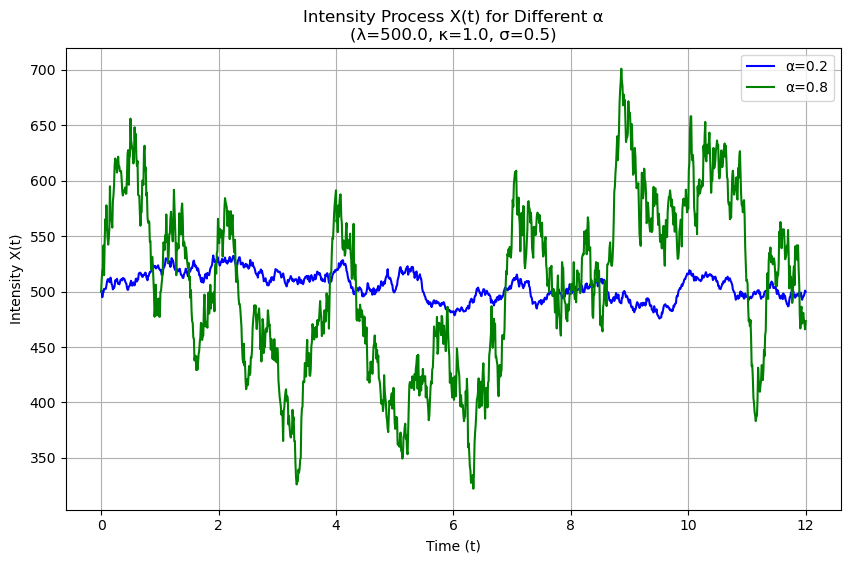

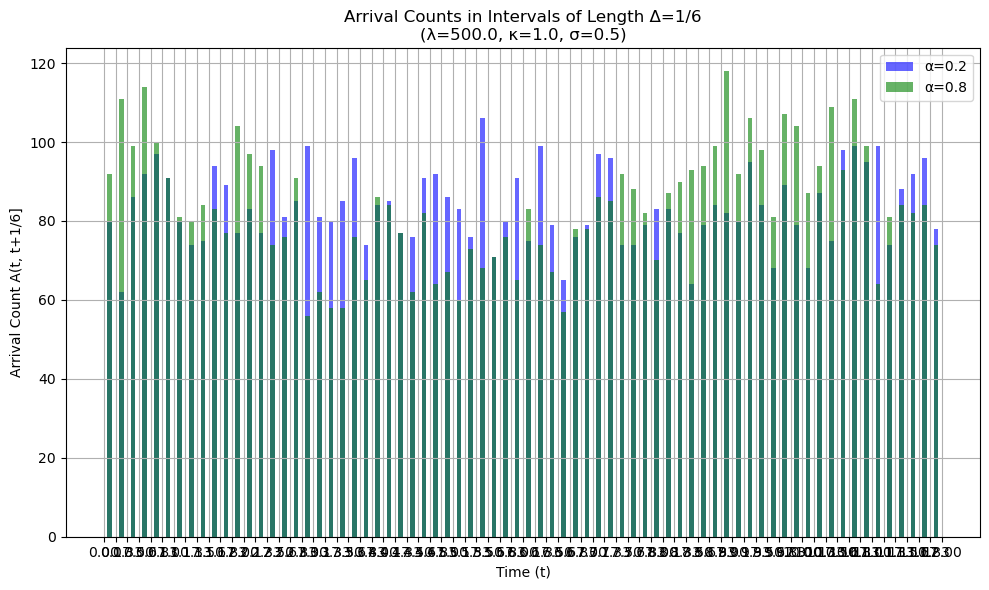

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

def simulate_rate_trajectory(sim_time, dt, lambda_, kappa, sigma, alpha):
    """Simulate X(t) using Euler-Maruyama method for the SDE."""
    time_steps = np.arange(0, sim_time + dt, dt)
    X = np.zeros(len(time_steps))
    X[0] = lambda_  # Initial rate
    for i in range(1, len(time_steps)):
        X_prev = X[i-1]
        drift = kappa * (lambda_ - X_prev) * dt
        diffusion = sigma * np.sqrt(lambda_ ** alpha * X_prev) * np.sqrt(dt) * np.random.normal()
        X[i] = max(X_prev + drift + diffusion, 0)  # Ensure non-negative
    return time_steps, X

def get_rate_at_time(t, time_steps, rate_trajectory, dt):
    """Interpolate X(t) at time t."""
    idx = int(t / dt)
    if idx >= len(rate_trajectory) - 1:
        return rate_trajectory[-1]
    frac = (t - idx * dt) / dt
    return rate_trajectory[idx] * (1 - frac) + rate_trajectory[idx + 1] * frac

def simulate_dspp(sim_time, time_steps, rate_trajectory, dt, lambda_max):
    """Simulate DSPP and return event times."""
    events = []
    t = 0
    while t < sim_time:
        t += -log(1 - np.random.random()) / lambda_max
        if t > sim_time:
            break
        rate = get_rate_at_time(t, time_steps, rate_trajectory, dt)
        if np.random.random() < rate / lambda_max:
            events.append(t)
    return np.array(events)

def count_arrivals(events, sim_time, delta):
    """Count arrivals in intervals [t, t+delta] for t = 0, delta, 2*delta, ..."""
    intervals = np.arange(0, sim_time, delta)
    counts = np.zeros(len(intervals))
    for i, t in enumerate(intervals):
        counts[i] = np.sum((events >= t) & (events < t + delta))
    return intervals, counts

def main():
    # Parameters
    lambda_ = 500.0  # Baseline arrival rate
    kappa = 1.0
    sigma = 0.5
    alpha_values = [0.2,0.8]  # Values of alpha to test
    sim_time = 12  # Simulation time
    dt = 0.01  # Time step for SDE
    lambda_max = 3 * lambda_  # Upper bound for thinning
    delta = 1/6  # Interval length for arrival counts

    # Set up plots
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    fig2, ax2 = plt.subplots(figsize=(10, 6))

    colors = ['blue', 'green', 'red', 'purple']  # Colors for different alpha

    for alpha, color in zip(alpha_values, colors):
        # Simulate intensity process
        time_steps, rate_trajectory = simulate_rate_trajectory(sim_time, dt, lambda_, kappa, sigma, alpha)
        
        # Plot X(t)
        ax1.plot(time_steps, rate_trajectory, label=f'α={alpha}', color=color, linewidth=1.5)
        
        # Simulate DSPP and count arrivals
        events = simulate_dspp(sim_time, time_steps, rate_trajectory, dt, lambda_max)
        intervals, counts = count_arrivals(events, sim_time, delta)
        
        # Plot arrival counts as a bar chart
        ax2.bar(intervals + delta/2, counts, width=delta*0.8/len(alpha_values), label=f'α={alpha}', alpha=0.6, align='center', color=color)

    # Customize intensity plot
    ax1.set_xlabel('Time (t)')
    ax1.set_ylabel('Intensity X(t)')
    ax1.set_title(f'Intensity Process X(t) for Different α\n(λ={lambda_}, κ={kappa}, σ={sigma})')
    ax1.legend()
    ax1.grid(True)

    # Customize arrival count plot
    ax2.set_xlabel('Time (t)')
    ax2.set_ylabel('Arrival Count A(t, t+1/6]')
    ax2.set_title(f'Arrival Counts in Intervals of Length Δ=1/6\n(λ={lambda_}, κ={kappa}, σ={sigma})')
    ax2.set_xticks(np.arange(0, sim_time + delta, delta))
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

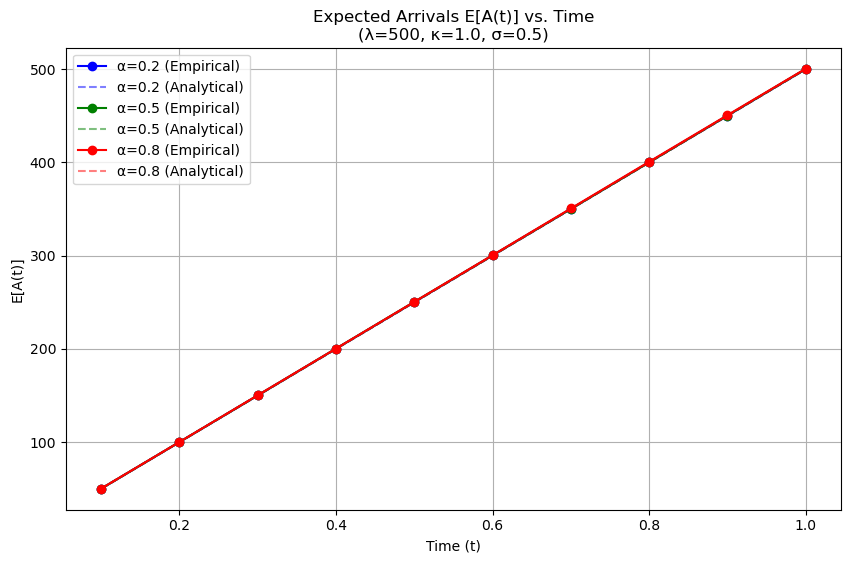

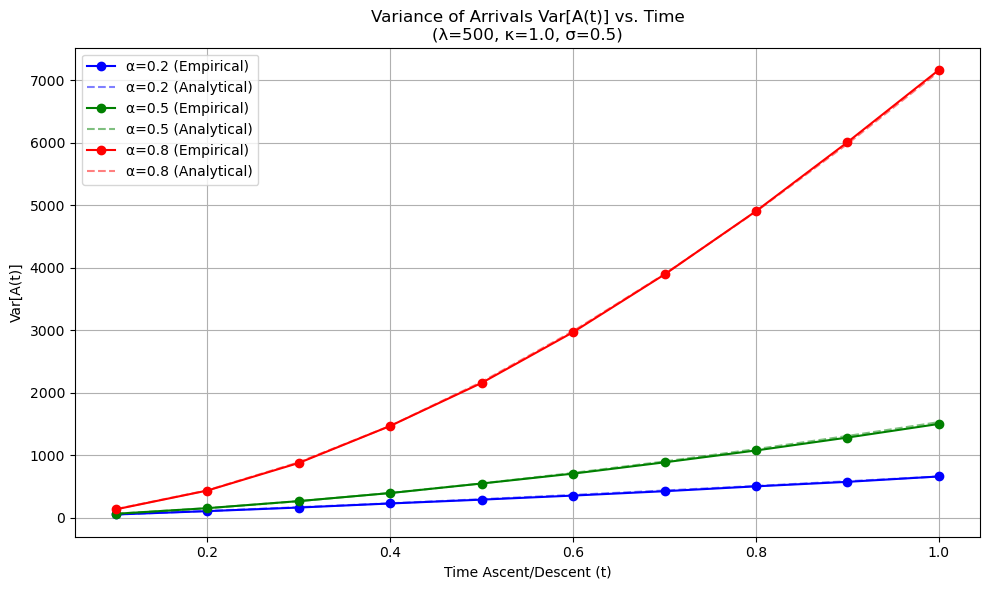

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

def simulate_rate_trajectory(sim_time, dt, lambda_, kappa, sigma, alpha):
    """Simulate X(t) using Euler-Maruyama with Gamma(a,b) initial condition."""
    a = 2 * kappa / (sigma**2 * lambda_**(alpha - 1))
    b = 2 * kappa / (sigma**2 * lambda_**alpha)
    time_steps = np.arange(0, sim_time + dt, dt)
    X = np.zeros(len(time_steps))
    X[0] = np.random.gamma(a, 1/b)  # Scale = 1/rate for NumPy
    for i in range(1, len(time_steps)):
        X_prev = X[i-1]
        drift = kappa * (lambda_ - X_prev) * dt
        diffusion = sigma * np.sqrt(lambda_**alpha * X_prev) * np.sqrt(dt) * np.random.normal()
        X[i] = max(X_prev + drift + diffusion, 0)
    return time_steps, X

def get_rate_at_time(t, time_steps, rate_trajectory, dt):
    """Interpolate X(t) at time t. Return X at any time t."""
    idx = int(t / dt)
    if idx >= len(rate_trajectory) - 1:
        return rate_trajectory[-1]
    frac = (t - idx * dt) / dt
    return rate_trajectory[idx] * (1 - frac) + rate_trajectory[idx + 1] * frac

def simulate_dspp(sim_time, time_steps, rate_trajectory, dt, lambda_max):
    """Simulate DSPP and return event times."""
    events = []
    t = 0
    while t < sim_time:
        # interarrival time: exp(lambda_max)
        t += -log(1 - np.random.random()) / lambda_max
        if t > sim_time:
            break
        rate = get_rate_at_time(t, time_steps, rate_trajectory, dt)
        if np.random.random() < rate / lambda_max:
            events.append(t)
    return np.array(events)

def analytical_variance(t, lambda_, kappa, sigma, alpha):
    """Compute analytical variance of A(t)."""
    term = (sigma**2 * lambda_**(alpha + 1) * t / kappa**2) * (1 - (1 - np.exp(-kappa * t)) / (kappa * t))
    return lambda_ * t + term

def main():
    # Parameters
    lambda_ = 500
    kappa = 1.0
    sigma = 0.5
    alpha_values = [0.2,0.5,0.8]  # Values of alpha to test
    sim_time = 1
    dt = 0.01
    lambda_max = 3 * lambda_
    num_paths = 5000
    t_values = np.linspace(0.1, sim_time, 10)  # Time points for A(t)

    # Set up plots
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'purple']

    for alpha, color in zip(alpha_values, colors):
        # Simulate multiple paths
        arrival_counts = np.zeros((num_paths, len(t_values)))
        for i in range(num_paths):
            time_steps, rate_trajectory = simulate_rate_trajectory(sim_time, dt, lambda_, kappa, sigma, alpha)
            events = simulate_dspp(sim_time, time_steps, rate_trajectory, dt, lambda_max)
            for j, t in enumerate(t_values):
                arrival_counts[i, j] = np.sum(events <= t)

        # Compute empirical mean and variance
        empirical_mean = np.mean(arrival_counts, axis=0)
        empirical_var = np.var(arrival_counts, axis=0)

        # Analytical values
        analytical_mean = lambda_ * t_values
        analytical_var = analytical_variance(t_values, lambda_, kappa, sigma, alpha)

        # Plot
        ax1.plot(t_values, empirical_mean, 'o-', label=f'α={alpha} (Empirical)', color=color)
        ax1.plot(t_values, analytical_mean, '--', label=f'α={alpha} (Analytical)', color=color, alpha=0.5)
        ax2.plot(t_values, empirical_var, 'o-', label=f'α={alpha} (Empirical)', color=color)
        ax2.plot(t_values, analytical_var, '--', label=f'α={alpha} (Analytical)', color=color, alpha=0.5)

    # Customize plots
    ax1.set_xlabel('Time (t)')
    ax1.set_ylabel('E[A(t)]')
    ax1.set_title(f'Expected Arrivals E[A(t)] vs. Time\n(λ={lambda_}, κ={kappa}, σ={sigma})')
    ax1.legend()
    ax1.grid(True)

    ax2.set_xlabel('Time Ascent/Descent (t)')
    ax2.set_ylabel('Var[A(t)]')
    ax2.set_title(f'Variance of Arrivals Var[A(t)] vs. Time\n(λ={lambda_}, κ={kappa}, σ={sigma})')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# Read Poisson

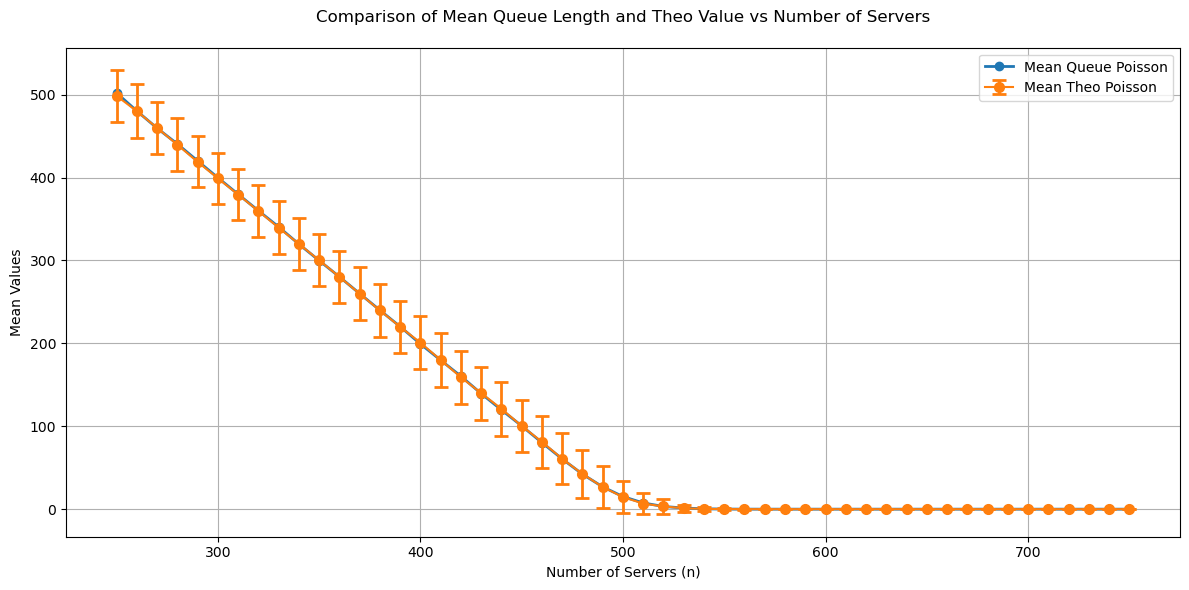

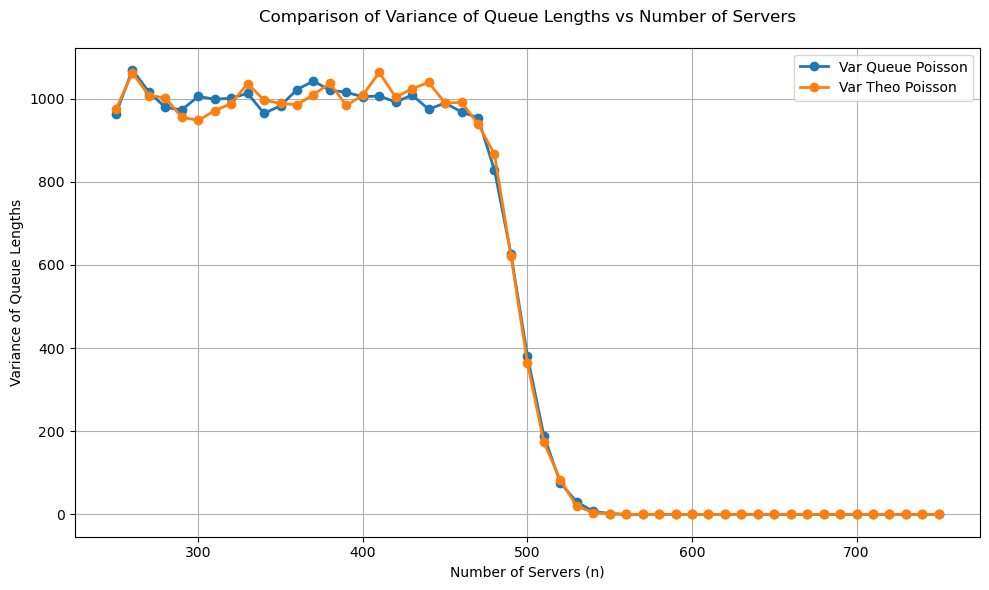

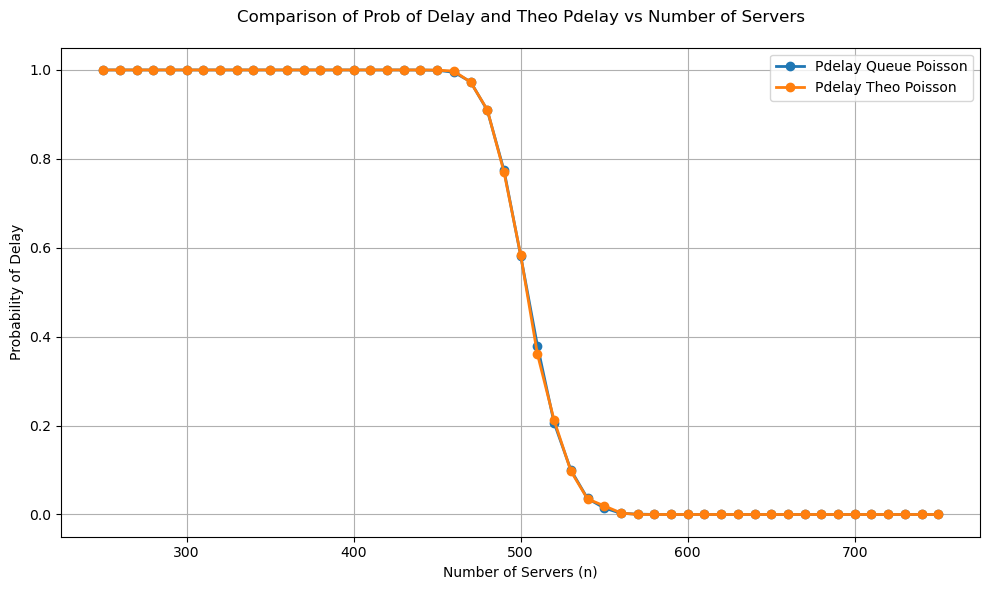

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from config_poisson import *

# read /home/jjiac/jinghan_hkust/Queue/data/poisson_queue_NIS.npy
nis_queue_poisson = np.load('/home/jjiac/jinghan_hkust/Queue/data/poisson_queue_NIS.npy')
nis_theo_poisson = np.load('/home/jjiac/jinghan_hkust/Queue/data/poisson_theo_NIS.npy')

# Organize results by n value
length_by_n = {n: [] for n in n_values}
for i, n in enumerate(np.repeat(list(n_values), num_paths_queue)):
    length_by_n[n].append(max(nis_queue_poisson[i]-n,0))

# Calculate mean queue length for each n
mean_queue_possion = []
for n in n_values:
    mean_queue_possion.append(np.mean(length_by_n[n]))

var_queue_possion = []
for n in n_values:
    var_queue_possion.append(np.var(length_by_n[n]))

p_delay_list = {n: [] for n in n_values}
for i, n in enumerate(np.repeat(list(n_values), num_paths_queue)):
    w = 1 if nis_queue_poisson[i] > n else 0
    p_delay_list[n].append(w)
pdelay_queue_possion = [np.mean(p_delay_list[n]) for n in n_values]

# Theoretical values for Poisson queue #########################################
# Storage for results
mean_theo_possion = []
std_theo_possion = []
# Storage for variance of final values
var_theo_possion = []
# Storage for probability of delay
pdelay_theo_possion = []

# Run simulations for each n value
for n in n_values:
    # find the idx of n
    idx = np.where(n_values == n)[0][0]
    final_values = nis_theo_poisson[idx]  # Get theoretical final values for this n

    # take max(0, final_values - n) to ensure non-negative values
    values = np.maximum(final_values - n, 0)
    mean_theo_possion.append(np.mean(values))
    std_theo_possion.append(np.std(values))
    # Calculate variance of final values
    var_theo_possion.append(np.var(values))

    # probability of delay
    p_delay_list = [1 if v > n else 0 for v in final_values]
    pdelay_theo_possion.append(np.mean(p_delay_list))

# plot upon n_values in one figure
plt.figure(figsize=(12, 6))
plt.plot(n_values, mean_queue_possion, 'o-', label='Mean Queue Poisson', linewidth=2, markersize=6)
plt.errorbar(n_values, mean_theo_possion, yerr=std_theo_possion, fmt='-o', 
             label='Mean Theo Poisson', capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Mean Values')
plt.title('Comparison of Mean Queue Length and Theo Value vs Number of Servers\n')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(10, 6))
plt.plot(n_values, var_queue_possion , 'o-',label='Var Queue Poisson', linewidth=2, markersize=6)
plt.plot(n_values, var_theo_possion, 'o-',label='Var Theo Poisson', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Variance of Queue Lengths')
plt.title('Comparison of Variance of Queue Lengths vs Number of Servers\n')
plt.grid(True)
plt.legend()
plt.tight_layout()

# plot p_delay and theo_p_delay in one figure
plt.figure(figsize=(10, 6))
plt.plot(n_values, pdelay_queue_possion, 'o-',label='Pdelay Queue Poisson', linewidth=2, markersize=6)
plt.plot(n_values, pdelay_theo_possion, 'o-',label='Pdelay Theo Poisson', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Probability of Delay')
plt.title('Comparison of Prob of Delay and Theo Pdelay vs Number of Servers\n')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

# Read DSPP

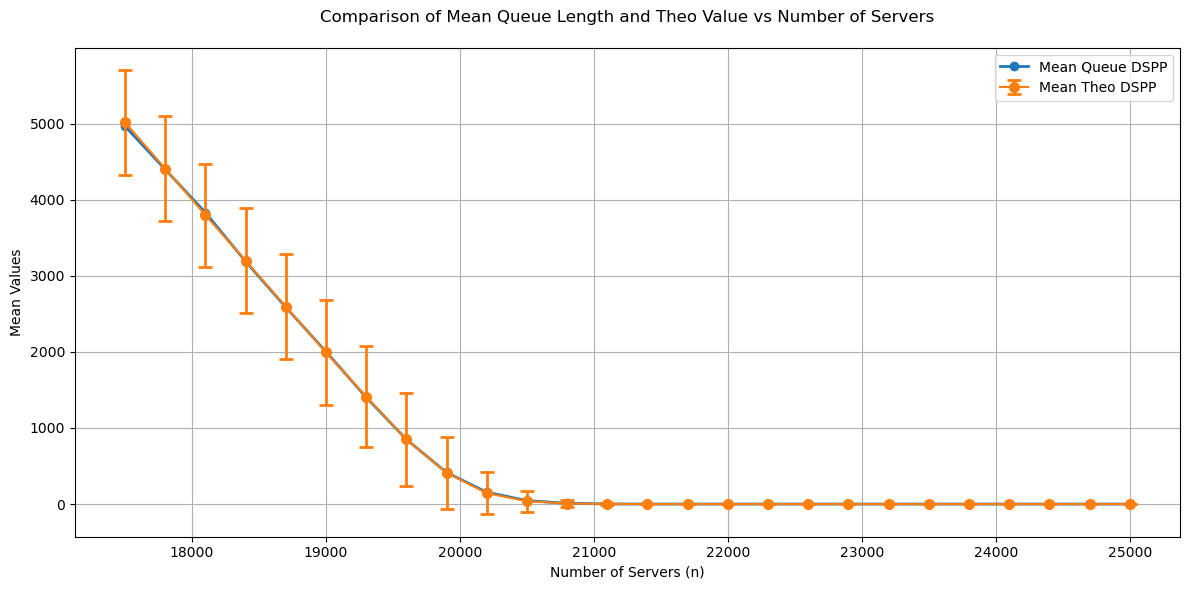

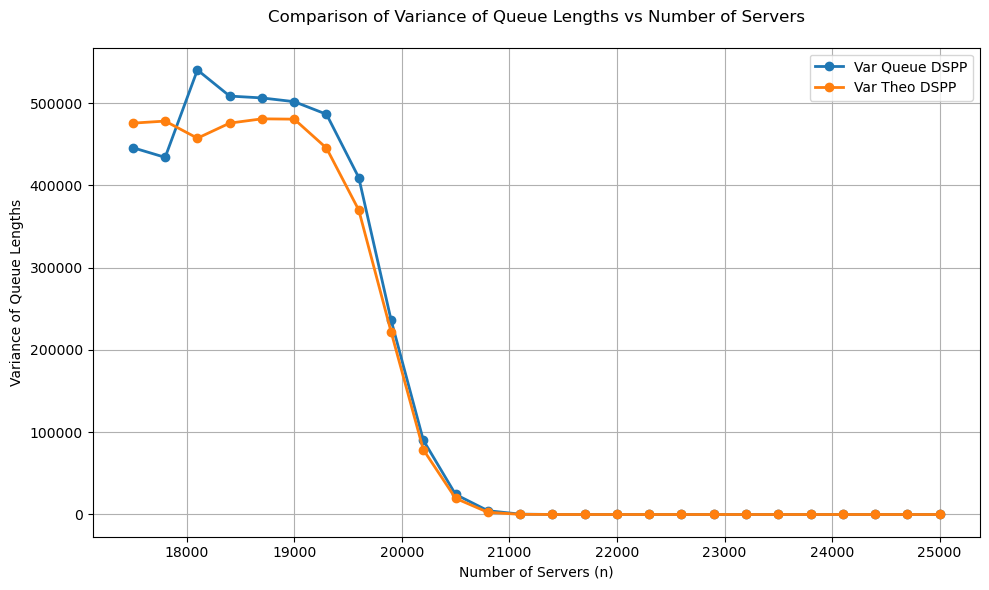

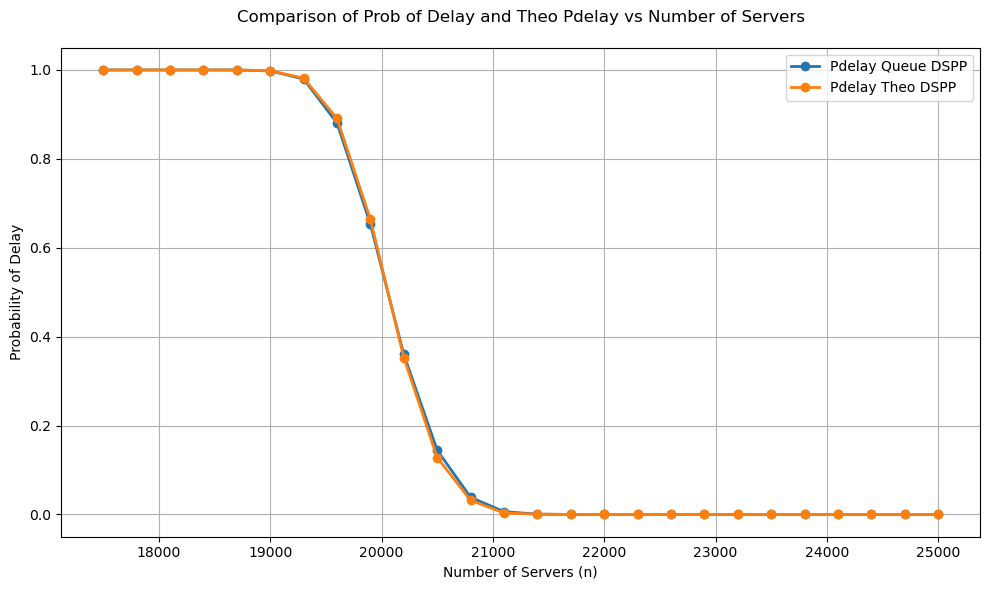

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from config_dspp import *

alpha = 0.5  # Set alpha for DSPP

# read /home/jjiac/jinghan_hkust/Queue/data/poisson_queue_NIS.npy
nis_queue_dspp = np.load(f'/home/jjiac/jinghan_hkust/Queue/data/dspp_queue_NIS_lambda20000.0_alpha{alpha}.npy')
nis_theo_dspp = np.load(f'/home/jjiac/jinghan_hkust/Queue/data/dspp_theo_NIS_lambda20000.0_alpha{alpha}.npy')

# Organize results by n value
n_values = np.linspace(17500, 25000, 26)
length_by_n = {n: [] for n in n_values}
for i, n in enumerate(np.repeat(list(n_values), num_paths_queue)):
    length_by_n[n].append(max(nis_queue_dspp[i]-n,0))

# Calculate mean queue length for each n
mean_queue_dspp = []
var_queue_dspp = []
for n in n_values:
    mean_queue_dspp.append(np.mean(length_by_n[n]))
    var_queue_dspp.append(np.var(length_by_n[n]))

p_delay_list = {n: [] for n in n_values}
for i, n in enumerate(np.repeat(list(n_values), num_paths_queue)):
    w = 1 if nis_queue_dspp[i] > n else 0
    p_delay_list[n].append(w)

pdelay_queue_dspp = [np.mean(p_delay_list[n]) for n in n_values]

# Theoretical values for DSPP queue ###########################################
# Store results
mean_theo_dspp = []
std_theo_dspp = []
var_theo_dspp = []
pdelay_theo_dspp = []

# Run simulations for each n
for n in n_values:
    # find the idx of n
    idx = np.where(n_values == n)[0][0]
    final_values = nis_theo_dspp[idx]  # Get theoretical final values for this n
    positive_values = np.maximum(final_values - n, 0)  # Ensure non-negative values
    mean_theo_dspp.append(np.mean(positive_values))
    std_theo_dspp.append(np.std(positive_values))
    var_theo_dspp.append(np.var(positive_values))

    pdelay_theo_dspp.append(np.mean(final_values > n))

# plot upon n_values in one figure
plt.figure(figsize=(12, 6))
plt.plot(n_values, mean_queue_dspp, 'o-', label='Mean Queue DSPP', linewidth=2, markersize=6)
plt.errorbar(n_values, mean_theo_dspp, yerr=std_theo_dspp, fmt='-o', 
             label='Mean Theo DSPP', capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Mean Values')
plt.title('Comparison of Mean Queue Length and Theo Value vs Number of Servers\n')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(10, 6))
plt.plot(n_values, var_queue_dspp , 'o-',label='Var Queue DSPP', linewidth=2, markersize=6)
plt.plot(n_values, var_theo_dspp, 'o-',label='Var Theo DSPP', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Variance of Queue Lengths')
plt.title('Comparison of Variance of Queue Lengths vs Number of Servers\n')
plt.grid(True)
plt.legend()
plt.tight_layout()

# plot p_delay and theo_p_delay in one figure
plt.figure(figsize=(10, 6))
plt.plot(n_values, pdelay_queue_dspp, 'o-',label='Pdelay Queue DSPP', linewidth=2, markersize=6)
plt.plot(n_values, pdelay_theo_dspp, 'o-',label='Pdelay Theo DSPP', linewidth=2, markersize=6)
plt.xlabel('Number of Servers (n)')
plt.ylabel('Probability of Delay')
plt.title('Comparison of Prob of Delay and Theo Pdelay vs Number of Servers\n')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

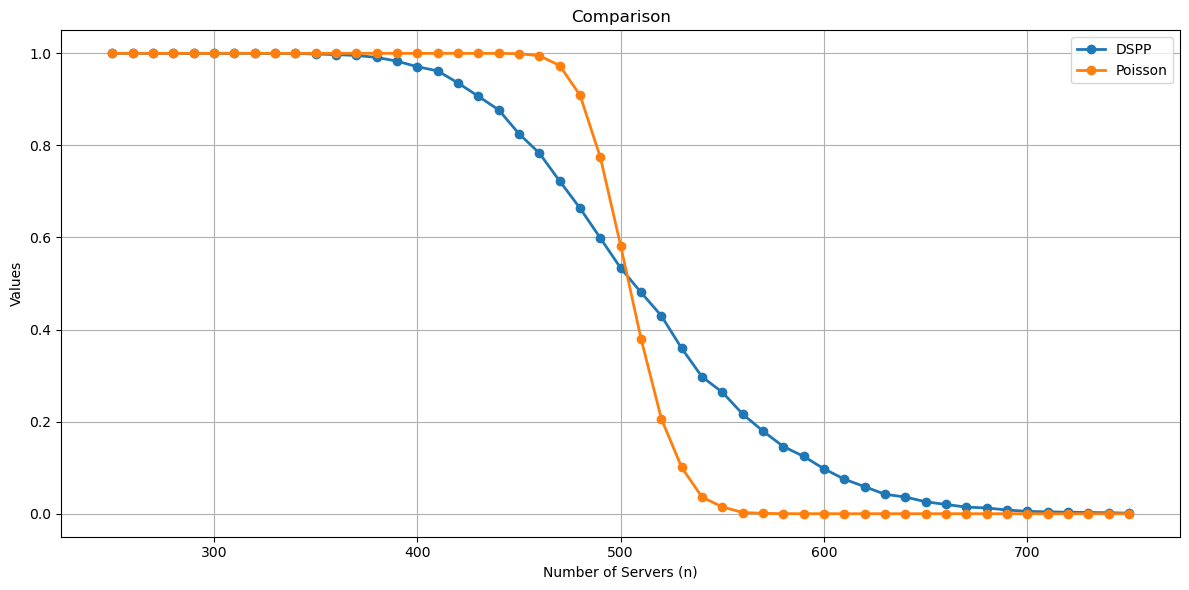

In [18]:
# plot mean_queue_lengths and theo_means upon n_values in one figure
plt.figure(figsize=(12, 6))
plt.plot(n_values, pdelay_queue_dspp, 'o-', label='DSPP', linewidth=2, markersize=6)
plt.plot(n_values, pdelay_queue_possion, 'o-', label='Poisson', linewidth=2, markersize=6)

plt.xlabel('Number of Servers (n)')
plt.ylabel('Values')
plt.title('Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

# Convergence of ADR

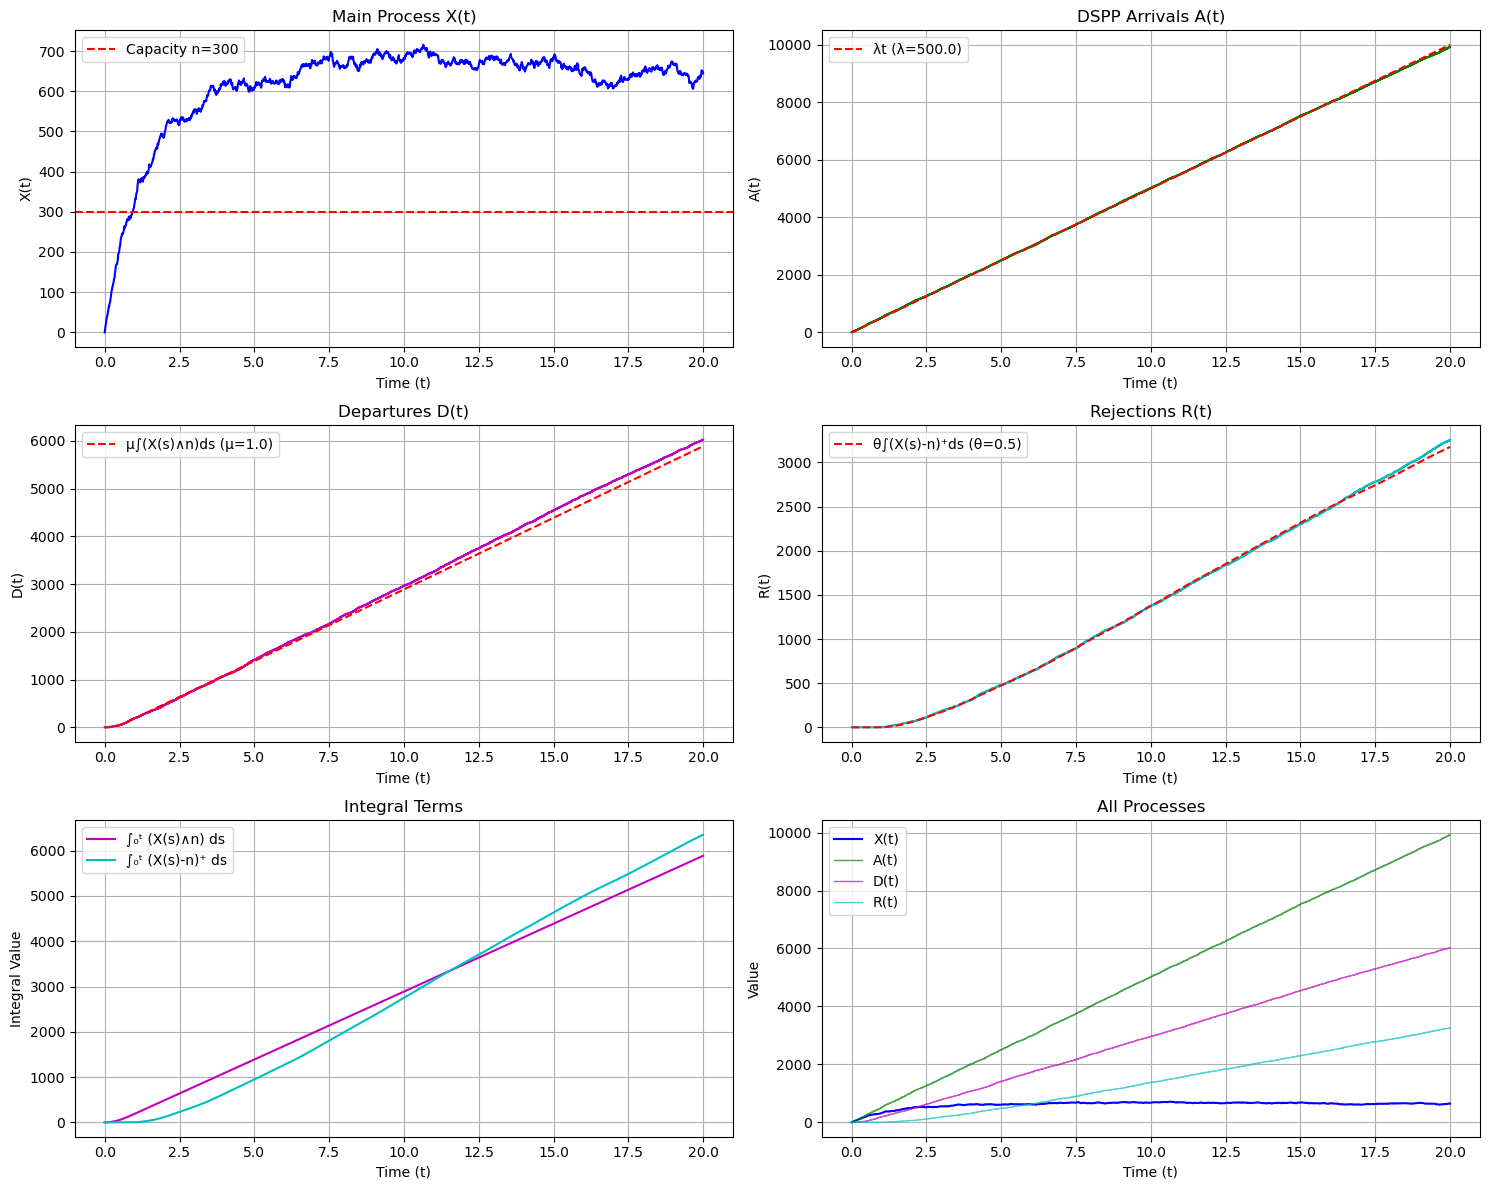

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
from scipy import interpolate

def simulate_rate_trajectory(sim_time, dt, lambda_, kappa, sigma, alpha):
    """Simulate X(t) using Euler-Maruyama method for the SDE."""
    n_steps = int(sim_time / dt) + 1
    time_steps = np.linspace(0, sim_time, n_steps)
    X = np.zeros(n_steps)
    X[0] = lambda_  # Initial rate
    
    # Precompute random numbers for efficiency
    dW = np.random.normal(0, 1, n_steps-1)
    
    for i in range(1, n_steps):
        X_prev = X[i-1]
        drift = kappa * (lambda_ - X_prev) * dt
        diffusion = sigma * np.sqrt(lambda_ ** alpha * max(X_prev, 0)) * np.sqrt(dt) * dW[i-1]
        X[i] = max(X_prev + drift + diffusion, 0)  # Ensure non-negative
        
    return time_steps, X

def simulate_dspp(sim_time, time_steps, rate_trajectory, dt, lambda_max):
    """Simulate DSPP using thinning method with interpolation."""
    # Create interpolation function for the rate trajectory
    interp_func = interpolate.interp1d(time_steps, rate_trajectory, 
                                      kind='linear', bounds_error=False, 
                                      fill_value=(rate_trajectory[0], rate_trajectory[-1]))
    
    events = []
    t = 0
    while t < sim_time:
        # Generate next candidate time
        t += -log(1 - np.random.random()) / lambda_max
        
        if t > sim_time:
            break
            
        # Get rate at time t using interpolation
        rate = interp_func(t)
        
        # Accept with probability rate/lambda_max
        if np.random.random() < rate / lambda_max:
            events.append(t)
            
    return np.array(events)

def simulate_sde_with_dspp(sim_time, dt, lambda_, mu, theta, n):
    """
    Simulate the SDE:
    X(t) = λt - μ∫₀ᵗ (X(s)∧n) ds - θ∫₀ᵗ (X(s)-n)⁺ ds + A(t) - D(t) - R(t)
    
    where:
    A(t) = DSPP(λt) - λt
    D(t) = S(μ∫₀ᵗ (X(s)∧n) ds) - μ∫₀ᵗ (X(s)∧n) ds
    R(t) = N(θ∫₀ᵗ (X(s)-n)⁺ ds) - θ∫₀ᵗ (X(s)-n)⁺ ds
    """
    # Time steps
    n_steps = int(sim_time / dt) + 1
    time_steps = np.linspace(0, sim_time, n_steps)
    
    # Initialize arrays
    X = np.zeros(n_steps)  # Main process
    integral_D = np.zeros(n_steps)  # ∫₀ᵗ (X(s)∧n) ds
    integral_R = np.zeros(n_steps)  # ∫₀ᵗ (X(s)-n)⁺ ds
    
    # DSPP simulation for A(t)
    # For simplicity, we'll use a constant intensity process for DSPP(λt)
    # In a more complex case, this could be made stochastic
    lambda_max_A = 2 * lambda_  # Upper bound for thinning
    A_events = simulate_dspp(sim_time, time_steps, 
                            lambda_ * np.ones_like(time_steps), 
                            dt, lambda_max_A)
    A_counts = np.zeros(n_steps)
    
    # Initialize Poisson processes for D(t) and R(t)
    D_counts = np.zeros(n_steps)
    R_counts = np.zeros(n_steps)
    
    # Initialize X(0)
    X[0] = 0
    
    # Simulate the process
    for i in range(1, n_steps):
        t = time_steps[i]
        
        # Update integrals using trapezoidal rule
        X_prev = X[i-1]
        integral_D[i] = integral_D[i-1] + 0.5 * dt * (min(X_prev, n) + min(X[i-1], n))
        integral_R[i] = integral_R[i-1] + 0.5 * dt * (max(X_prev - n, 0) + max(X[i-1] - n, 0))
        
        # Count A events up to time t
        A_counts[i] = np.sum(A_events <= t)
        
        # Simulate Poisson processes D and R
        # D(t) ~ Poisson(μ * integral_D[i])
        expected_D = mu * integral_D[i]
        D_counts[i] = np.random.poisson(expected_D - mu * integral_D[i-1]) + D_counts[i-1]
        
        # R(t) ~ Poisson(θ * integral_R[i])
        expected_R = theta * integral_R[i]
        R_counts[i] = np.random.poisson(expected_R - theta * integral_R[i-1]) + R_counts[i-1]
        
        # Update X(t)
        A_t = A_counts[i] - lambda_ * t  # A(t) = DSPP(λt) - λt
        D_t = D_counts[i] - mu * integral_D[i]  # D(t) = S(μ∫) - μ∫
        R_t = R_counts[i] - theta * integral_R[i]  # R(t) = N(θ∫) - θ∫
        
        X[i] = lambda_ * t - mu * integral_D[i] - theta * integral_R[i] + A_t - D_t - R_t
    
    return time_steps, X, A_counts, D_counts, R_counts, integral_D, integral_R

def main():
    # Parameters
    sim_time = 20.0  # Simulation time
    dt = 0.01  # Time step
    lambda_ = 500.0  # Arrival rate
    mu = 1.0  # Service rate
    theta = 0.5  # Rejection rate
    n = 300  # Capacity threshold
    
    # Simulate the SDE
    time_steps, X, A_counts, D_counts, R_counts, integral_D, integral_R = simulate_sde_with_dspp(
        sim_time, dt, lambda_, mu, theta, n)
    
    # Create plots
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Plot 1: Main process X(t)
    axes[0, 0].plot(time_steps, X, 'b-', linewidth=1.5)
    axes[0, 0].axhline(y=n, color='r', linestyle='--', label=f'Capacity n={n}')
    axes[0, 0].set_xlabel('Time (t)')
    axes[0, 0].set_ylabel('X(t)')
    axes[0, 0].set_title('Main Process X(t)')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot 2: DSPP Arrivals A(t)
    axes[0, 1].step(time_steps, A_counts, 'g-', where='post', linewidth=1.5)
    axes[0, 1].plot(time_steps, lambda_ * time_steps, 'r--', label=f'λt (λ={lambda_})')
    axes[0, 1].set_xlabel('Time (t)')
    axes[0, 1].set_ylabel('A(t)')
    axes[0, 1].set_title('DSPP Arrivals A(t)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot 3: Departures D(t)
    axes[1, 0].step(time_steps, D_counts, 'm-', where='post', linewidth=1.5)
    axes[1, 0].plot(time_steps, mu * integral_D, 'r--', label=f'μ∫(X(s)∧n)ds (μ={mu})')
    axes[1, 0].set_xlabel('Time (t)')
    axes[1, 0].set_ylabel('D(t)')
    axes[1, 0].set_title('Departures D(t)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot 4: Rejections R(t)
    axes[1, 1].step(time_steps, R_counts, 'c-', where='post', linewidth=1.5)
    axes[1, 1].plot(time_steps, theta * integral_R, 'r--', label=f'θ∫(X(s)-n)⁺ds (θ={theta})')
    axes[1, 1].set_xlabel('Time (t)')
    axes[1, 1].set_ylabel('R(t)')
    axes[1, 1].set_title('Rejections R(t)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # Plot 5: Integrals
    axes[2, 0].plot(time_steps, integral_D, 'm-', label='∫₀ᵗ (X(s)∧n) ds', linewidth=1.5)
    axes[2, 0].plot(time_steps, integral_R, 'c-', label='∫₀ᵗ (X(s)-n)⁺ ds', linewidth=1.5)
    axes[2, 0].set_xlabel('Time (t)')
    axes[2, 0].set_ylabel('Integral Value')
    axes[2, 0].set_title('Integral Terms')
    axes[2, 0].legend()
    axes[2, 0].grid(True)
    
    # Plot 6: All components together
    axes[2, 1].plot(time_steps, X, 'b-', label='X(t)', linewidth=1.5)
    axes[2, 1].step(time_steps, A_counts, 'g-', where='post', label='A(t)', linewidth=1.0, alpha=0.7)
    axes[2, 1].step(time_steps, D_counts, 'm-', where='post', label='D(t)', linewidth=1.0, alpha=0.7)
    axes[2, 1].step(time_steps, R_counts, 'c-', where='post', label='R(t)', linewidth=1.0, alpha=0.7)
    axes[2, 1].set_xlabel('Time (t)')
    axes[2, 1].set_ylabel('Value')
    axes[2, 1].set_title('All Processes')
    axes[2, 1].legend()
    axes[2, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()